In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
import os
from pathlib import Path

# Load data
path = Path(os.getcwd() + "/..").resolve()
path='C:/Users/Hp/OneDrive/Desktop/DL coursework/Dubai_PG9/Datasets/Tabular/FOOD-DATA-GROUP.csv'
df=pd.read_csv(path)

df = df.drop("food", axis=1)
features = df.drop("Caloric Value", axis=1).columns.tolist()
target = "Caloric Value"

In [22]:
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform the data
df_transformed = pt.fit_transform(df)

# Convert back to DataFrame
df = pd.DataFrame(df_transformed, columns=df.columns)

In [23]:
# Column added for feature extraction
df['Protein+Carbohydrates+Fat'] = df['Protein']+df['Carbohydrates']+df['Fat']

In [24]:
selected_features = ['Nutrition Density', 'Monounsaturated Fats', 'Phosphorus', 'Calcium', 'Sodium', 'Vitamin B11', 'Dietary Fiber', 'Copper', 'Selenium', 'Protein+Carbohydrates+Fat']
X = df[selected_features]
y = df[target]

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression()


In [27]:
from sklearn.tree import DecisionTreeRegressor

dec_tree_param_grid = [{
    'max_depth': [2, 4, 7, 10],
    'min_samples_split': [2, 4, 7, 10],
    'min_samples_leaf': [2, 4, 7, 10]
    }]
dec_tree_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), dec_tree_param_grid, cv=5, scoring='r2')
dec_tree_grid_search.fit(X, y)
dec_tree_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=7, random_state=42)

In [28]:
# Initalize DecisionTreeRegressor with hyperparameters based on the best estimator from GridSearchCV
dec_tree_model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=7, random_state=42)

In [29]:
from sklearn.ensemble import RandomForestRegressor

forest_reg_param_grid = [{
    'n_estimators': [3, 10, 30],
    'min_samples_split': [2, 4, 7, 10],
    'min_samples_leaf': [2, 4, 7, 10]
    }]
forest_reg_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), forest_reg_param_grid, cv=5, scoring='r2')
forest_reg_grid_search.fit(X, y)
forest_reg_grid_search.best_estimator_

RandomForestRegressor(min_samples_leaf=2, min_samples_split=7, n_estimators=30,
                      random_state=42)

In [30]:
# Initalize RandomForestRegressor with hyperparameters based on the best estimator from GridSearchCV
forest_reg_model = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, min_samples_split=7, random_state=42)

In [31]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Test size from 0.01 to 0.99 inclusive
test_sizes = np.arange(0.01, 1.00, 0.01)
test_samples = []
lin_reg_r2_scores = []
dec_tree_r2_scores = []
forest_reg_r2_scores = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    test_samples.append(X_test.shape[0])

    # Linear Regression
    lin_reg_model.fit(X_train, y_train)
    lin_reg_pred = lin_reg_model.predict(X_test)
    # Calculate R2 score and add to list
    lin_reg_r2_scores.append(r2_score(y_test, lin_reg_pred))

    # Decision Tree Regressor
    dec_tree_model.fit(X_train, y_train)
    dec_tree_pred = dec_tree_model.predict(X_test)
    # Calculate R2 score and add to list
    dec_tree_r2_scores.append(r2_score(y_test, dec_tree_pred))

    # Random Forest Regressor
    forest_reg_model.fit(X_train, y_train)
    forest_reg_pred = forest_reg_model.predict(X_test)
    # Calculate R2 score and add to list
    forest_reg_r2_scores.append(r2_score(y_test, forest_reg_pred))

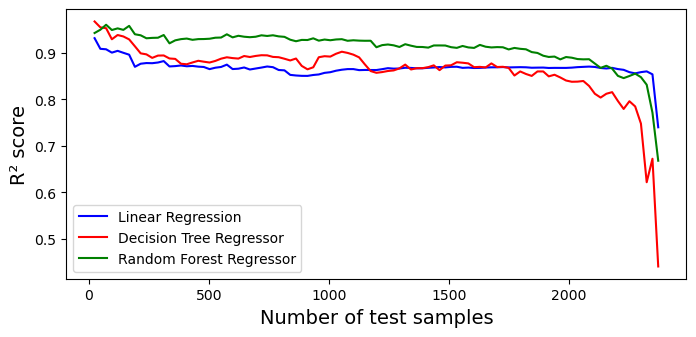

In [32]:
plt.figure(figsize=(8, 3.5))

plt.plot(test_samples, lin_reg_r2_scores, "b", label="Linear Regression")
plt.plot(test_samples, dec_tree_r2_scores, "r", label="Decision Tree Regressor")
plt.plot(test_samples, forest_reg_r2_scores, "g", label="Random Forest Regressor")

plt.xlabel("Number of test samples", fontsize=14)
plt.ylabel("R² score", fontsize=14)

plt.legend()

plt.show()

In [33]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define a function to perform hyperparameter tuning and analyze the results
def hyperparameter_investigation(X_train, X_test, y_train, y_test):
    # Define the hyperparameters to be tested
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.2, 0.5, 0.3]
    }
    
    # Initialize the model
    svr = SVR()
    
    # Initialize GridSearchCV with cross-validation and scoring metric
    grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Extract results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Test the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    
    # Best hyperparameters and their performance on the test set
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_  # Convert to positive mean squared error
    
    return results, best_params, best_score, test_mse

# Execute the investigation with the train/test data
results, best_params, best_score, test_mse = hyperparameter_investigation(X_train, X_test, y_train, y_test)

# Display the results
print("Results summary:")
print(results.head())
print("Best hyperparameters:", best_params)
print("Best cross-validation MSE:", best_score)
print("Test set MSE:", test_mse)


Results summary:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.002690      0.000357         0.002299        0.000411     0.1   
1       0.002264      0.000402         0.002085        0.000095     0.1   
2       0.001869      0.000737         0.001135        0.000184     0.1   
3       0.001993      0.000540         0.001328        0.000454     0.1   
4       0.002254      0.000495         0.002155        0.000834     0.1   

  param_epsilon param_gamma                                        params  \
0           0.1       scale  {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale'}   
1           0.1       0.001    {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.001}   
2           0.1        0.01     {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.01}   
3           0.1         0.1      {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.1}   
4           0.1           1        {'C': 0.1, 'epsilon': 0.1, 'gamma': 1}   

   split0_test_score  split1_test_score  split2_test_score  split3_te